### Your very own neural network

In this notebook we're going to build a neural network using naught but pure numpy and steel nerves. It's going to be fun, I promise!

<img src="frankenstein.png" style="width:20%">

In [1]:
import sys
sys.path.append("..")
import tqdm_utils
import download_utils

In [2]:
# use the preloaded keras datasets and models
download_utils.link_all_keras_resources()

In [3]:
from __future__ import print_function
import numpy as np
np.random.seed(42)

This is a Abstract Layer class and hence every layer which we will implement in future must inherit layer and implement forward and backword pass

In [4]:
class Layer:
    def __init__(self):
        """initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input, train):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        d loss / d layer = input, so you only nee
        update your parameters
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### The road ahead

We're going to build a neural network that classifies MNIST digits. To do so, we'll need a few building blocks:
- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- ReLU layer (or any other nonlinearity you want)
- Loss function - crossentropy
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.


### Nonlinearity layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [ ]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        self.details="Activation"
    
    def forward(self, input,train=True):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        # <your code. Try np.
        mat = input >= 0
        return np.multiply(input,mat)
    
    def backward(self, input, grad_output,debug=False):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad        

In [6]:
# some tests
from util import eval_numerical_gradient
x = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(x,np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called.

In [16]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1,init="xavier",dropout=0):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        # %age of neurons to keep in each iteration 
        self.keep_prob=1-dropout
        
        self.details="Dense:in %s,out %s" %(input_units,output_units)
        
        if (init == "xavier"):
            self.weights = np.random.randn(input_units, output_units)*np.sqrt(2/input_units)
        else:
            self.weights = np.random.randn(input_units, output_units)*0.01
        
        self.biases = np.zeros(output_units)
        
        
    def forward(self,input,train=True):
        w=self.weights
        if train:
            shape=self.weights.shape
            # mask becomes a matrix of 0 and 1 
            self.mask=np.random.binomial(1,self.keep_prob,size=shape)
            w=np.multiply(self.mask,w)
            # to ensure expected value remains the same
            w=w/self.keep_prob
        
        return np.dot(input,w)+self.biases
    
    def backward(self,input,grad_output,debug=False):
        # compute d f / d x = d f / d dense * d dense / d x
        # d dense/ d x = weights transposed
        # d f / d dense = grad_output
        # grad_input = d Loss / d curr_layer  *  d curr_layer / d prev_layer
        grad_input = np.dot(grad_output,self.weights.T) 
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T,grad_output)
        grad_biases = np.sum(grad_output,axis=0)
        if debug:
            print("w",self.weights)
            print("m",self.mask)
            print("gdw",grad_weights)
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        #SGD
        #we apply the same mask again which was generated during the fwd pass
        #to ensure that we dont update the weights which were off
        self.weights = self.weights - self.learning_rate * grad_weights * self.mask
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If you write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If you take a closer look, ya'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

Here you are! We've defined the both loss functions for you so that you could focus on neural network part.

In [17]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [18]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

### Full network

Now let's combine what we've just built into a working neural network. As we announced, we're gonna use this monster to classify handwritten digits, so let's get them loaded.

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [20]:
# network without xavier init
network = [
    Dense(X_train.shape[1],16),
    ReLU(),
    Dense(16,32),
    ReLU(),
    Dense(32,32),
    ReLU(),
    Dense(32,64),
    ReLU(),
    Dense(64,128,dropout=0.2),
    ReLU(),
    Dense(128,10)
]

# network with xavier init
networkX = [
    Dense(X_train.shape[1],16,init="xavier"),
    ReLU(),
    Dense(16,32,init="xavier"),
    ReLU(),
    Dense(32,32,init="xavier"),
    ReLU(),
    Dense(32,64,init="xavier"),
    ReLU(),
    Dense(64,128,init="xavier",dropout=0.2),
    ReLU(),
    Dense(128,10,init="xavier")
]

In [21]:
def forward(network, X,train=True):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    for layer in network:
        activations.append(layer.forward(input,train))
        input=activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X,train=False)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y,debug=False):
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    layer_inputs.pop()
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    grad_input=loss_grad
    for layer,input in zip(network[::-1],layer_inputs[::-1]):
        grad_input=layer.backward(input,grad_input,debug)
        
    return np.mean(loss)

### Training loop

As usual, we split data into minibatches, feed each such minibatch into the network and update weights.

In [22]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm_utils.tqdm_notebook_failsafe(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [23]:
from IPython.display import clear_output
train_log = []
val_log = []

train_logX = []
val_logX = []

Epoch 9
Train acc: Net:0.9564 NetX:0.95958
Val acc:Net:0.9503 NetX:0.9554


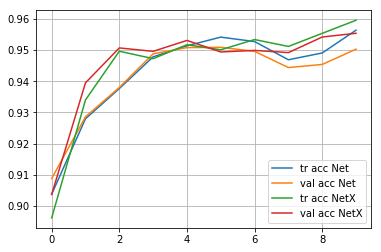

In [24]:
for epoch in range(10):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
        train(networkX,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    train_logX.append(np.mean(predict(networkX,X_train)==y_train))
    val_logX.append(np.mean(predict(networkX,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train acc: Net:{} NetX:{}".format(train_log[-1],train_logX[-1]))
    print("Val acc:Net:{} NetX:{}".format(val_log[-1],val_logX[-1]))
    plt.plot(train_log,label='tr acc Net')
    plt.plot(val_log,label='val acc Net')
    plt.plot(train_logX,label='tr acc NetX')
    plt.plot(val_logX,label='val acc NetX')
    
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    